In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-08-08 16:56:03.736893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:56:04.118024: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
def get_min(Ref, Array):
    return np.argmin(np.abs(Ref - Array))

In [3]:
def add_more_cols(DF):
    DF["P1M"] = (DF["Mjj_msortedP1_high"] + DF["Mjj_msortedP1_low"]) / 2
    DF["P2M"] = (DF["Mjj_msortedP2_high"] + DF["Mjj_msortedP2_low"]) / 2
    DF["P3M"] = (DF["Mjj_msortedP3_high"] + DF["Mjj_msortedP3_low"]) / 2
    
    DF["dRi"] = DF.apply(lambda row: get_min(row["Mjj_avg_dRpairing_GeV"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    DF["Truth_high"] = DF.apply(lambda row: get_min(row["Mass"], np.array([row["Mjj_msortedP1_high"], 
                                row["Mjj_msortedP2_high"], row["Mjj_msortedP3_high"]])), axis = 1)
    DF["Truth_avg"] = DF.apply(lambda row: get_min(row["Mass"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    
    DF["P1QSMD"] = (DF["Mjj_msortedP1_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP1_low"] - DF["Mass"])**2
    DF["P2QSMD"] = (DF["Mjj_msortedP2_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP2_low"] - DF["Mass"])**2
    DF["P3QSMD"] = (DF["Mjj_msortedP3_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP3_low"] - DF["Mass"])**2
    
    DF["Truth_QSMD"] = DF.apply(lambda row: get_min(0, 
                                np.array([row["P1QSMD"], row["P2QSMD"], row["P3QSMD"]])), axis = 1)
    
    DF["y1_sum"] = abs(DF["y12"] + DF["y34"])
    DF["y1_diff"] = abs(DF["y12"] - DF["y34"])
    DF["y2_sum"] = abs(DF["y13"] + DF["y24"])
    DF["y2_diff"] = abs(DF["y13"] - DF["y24"])
    DF["y3_sum"] = abs(DF["y14"] + DF["y23"])
    DF["y3_diff"] = abs(DF["y14"] - DF["y23"])

In [4]:
def normalize_inouts(DF):
    GevCols = ["Mjj_msortedP1_high", "Mjj_msortedP1_low", "Mjj_msortedP2_high", "Mjj_msortedP2_low", 
               "Mjj_msortedP3_high", "Mjj_msortedP3_low", "Mjj_avg_dRpairing_GeV",
               "pt_ordered_jet1_pt", "pt_ordered_jet2_pt", "pt_ordered_jet3_pt", "pt_ordered_jet4_pt"]
    for GevCol in GevCols:
        DF[GevCol] = DF[GevCol] / 1000
        
    return DF

In [5]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(library="pd")
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    DF["Mass"] = Mass
    add_more_cols(DF)
    normalize_inouts(DF)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [6]:
Masses = [500, 600, 700, 800, 900, 1000]

NotebookName = "quad_sum_mass_diff"
PlotsDir = "plots/plots_" + NotebookName + "/"
if not os.path.exists(PlotsDir):
    os.makedirs(PlotsDir)

In [7]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, Masses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root




Memory used: 0.49381256103515625GB


In [8]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 500]
TrainingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff
0,0.459736,-0.731325,0.492579,-0.572288,-0.136930,0.075227,1.437438,0.589512,0.483189,0.372651,0.847387,0.330702,0.694555,0.515225,0.535663,0.462190,0.498926,0.352612,0.773682,-1.982666,29.824646,0.300181,0.102753,1.098877,57.910728,0.212220,0.038391,-0.279114,12.978419,0.164810,-1.678955,2.421387,19.934750,1,500,589.044722,604.889669,498.926253,2,2,2,1.493393e+05,3.808332e+04,2701.446450,2,0.271589,1.191061,0.079709,1.064867,0.061702,0.212157
1,0.177537,-0.046975,0.196526,0.058371,0.045306,0.222323,1.372216,0.731474,0.360959,0.326251,1.003741,0.124972,0.495314,0.481617,0.447687,0.432799,0.564357,0.570987,0.163818,-2.839844,31.241617,0.514659,0.193359,1.086914,30.595160,0.142111,0.331055,-1.069336,22.435198,0.122446,-0.483154,-0.718750,12.957661,1,500,564.356654,488.465821,440.242900,0,1,1,3.944005e+05,3.598749e+02,7252.644284,1,0.130562,0.224513,0.254897,0.138155,0.267628,0.177017
2,1.138567,-0.880824,-0.476845,1.483183,0.345174,0.359891,2.415887,0.773636,0.421770,0.326372,1.869017,0.353732,1.018949,0.484321,0.788478,0.574264,0.681371,0.403701,0.345154,-0.989380,39.566208,0.341872,2.052734,1.669922,26.953323,0.181515,-1.941406,-1.693604,23.153996,0.146286,0.351501,-2.593750,15.604961,1,500,1111.374763,751.635244,681.370897,2,2,2,1.895603e+06,2.695539e+05,88734.467306,2,0.257743,2.019391,1.006339,1.960028,0.705064,0.014717
3,0.750664,-1.096145,0.298671,-0.234110,0.306175,-0.194680,1.927872,0.589096,0.496342,0.458295,1.135702,0.642779,0.956883,0.457008,0.883534,0.342234,0.706946,0.493272,1.074463,2.465332,29.843073,0.379818,0.339478,-0.009506,37.778255,0.281791,-0.893677,-0.426331,40.116997,0.136930,-1.526611,-2.263184,18.419775,1,500,889.240451,706.945693,612.884215,1,2,2,4.245027e+05,2.105906e+05,171988.564353,2,0.345481,1.846808,0.064561,0.532781,0.111494,0.500855
4,-0.508460,-0.847235,-0.673451,-0.477038,-0.610471,-0.564505,1.149871,0.741729,0.417437,0.325977,0.852893,0.145379,0.479999,0.410948,0.374831,0.205845,0.290338,0.467451,-0.590088,-0.751343,52.325665,0.402578,-0.418518,2.844238,32.207481,0.165139,-0.919800,0.644287,13.693277,0.094380,-0.736328,1.830078,17.022684,1,500,499.135929,445.473416,290.337796,2,1,0,2.502898e+05,8.330356e+03,102194.712630,1,1.355695,0.338775,1.150489,0.196414,1.174976,0.045966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.277664,1.150011,0.891934,0.313344,-0.000250,1.254213,2.841756,0.649734,0.429855,0.355870,1.846385,0.803010,1.221544,0.865172,1.011294,0.880624,0.945959,0.739421,0.062714,0.686768,48.579727,0.554956,0.563843,-0.689575,41.766483,0.506572,2.005371,-2.677246,45.180443,0.277655,-0.167267,3.130859,49.997803,1,1000,1324.697282,1043.357783,945.958906,2,2,1,7.551726e+05,6.726015e+04,14378.301581,2,1.427675,0.872346,1.205278,0.578589,1.253963,1.254463
599996,-0.018123,1.218279,0.755928,0.176343,0.320142,0.650531,1.805384,0.544706,0.537255,0.434385,0.983403,0.420415,0.969952,0.416120,0.784231,0.628141,0.701909,0.445127,0.098938,0.099365,23.230692,0.419165,-0.142456,2.329590,24.714310,0.384834,1.503418,-2.083496,40.910538,0.222721,0.755737,1.311035,34.011597,1,1000,701.908942,693.035728,706.186430,0,0,2,3.361945e+05,3.418188e+05,184834.870347,2

In [9]:
TrainingDF.dtypes

y12                          float32
y34                          float32
y13                          float32
y24                          float32
y14                          float32
y23                          float32
fourjetmasstev               float64
Mjj_msortedP1_high_div4jm    float64
Mjj_msortedP2_high_div4jm    float64
Mjj_msortedP3_high_div4jm    float64
Mjj_msortedP1_high           float64
Mjj_msortedP1_low            float64
Mjj_msortedP2_high           float64
Mjj_msortedP2_low            float64
Mjj_msortedP3_high           float64
Mjj_msortedP3_low            float64
Mjj_avg_dRpairing_GeV        float32
pt_ordered_jet1_pt           float32
pt_ordered_jet1_eta          float32
pt_ordered_jet1_phi          float32
pt_ordered_jet1_m            float32
pt_ordered_jet2_pt           float32
pt_ordered_jet2_eta          float32
pt_ordered_jet2_phi          float32
pt_ordered_jet2_m            float32
pt_ordered_jet3_pt           float32
pt_ordered_jet3_eta          float32
p

(array([100000., 100000., 100000., 100000., 100000., 100000.]),
 array([ 450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <BarContainer object of 6 artists>)

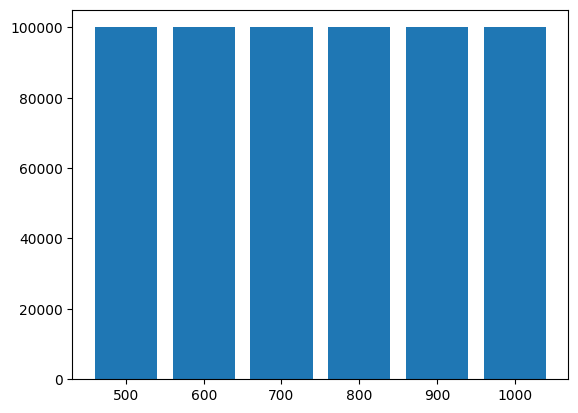

In [10]:
plt.hist(TrainingDF["Mass"], bins = len(Masses), range = [450, 1050], rwidth = 0.8)

(array([50000., 50000., 50000., 50000., 50000., 50000.]),
 array([ 450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <BarContainer object of 6 artists>)

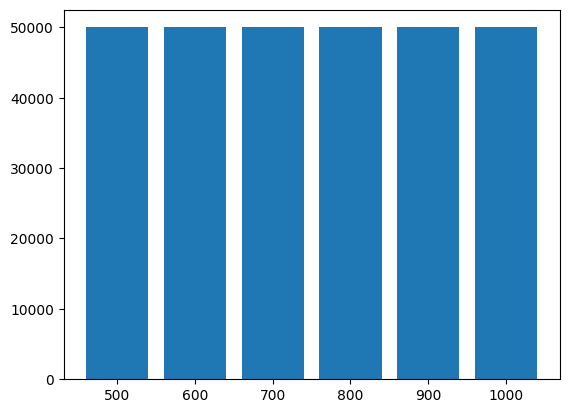

In [11]:
plt.hist(TestingDF["Mass"], bins = len(Masses), range = [450, 1050], rwidth = 0.8)

In [12]:
InputList = ["fourjetmasstev", "Mjj_msortedP1_high", "Mjj_msortedP1_low", "Mjj_msortedP2_high", "Mjj_msortedP2_low",
             "Mjj_msortedP3_high", "Mjj_msortedP3_low", "y1_sum", "y1_diff", "y2_sum", "y2_diff", "y3_sum", "y3_diff"]

TrainingInputs = TrainingDF[InputList].to_numpy()
TrainingTruth = TrainingDF["Truth_QSMD"].to_numpy()

TestingInputs = TestingDF[InputList].to_numpy()

In [13]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(600000, 13)
(600000,)
(300000, 13)


In [19]:
def model_DNN_lite():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(len(InputList), ), name="model_in"),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelDNNLite"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [20]:
def model_DNN():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(len(InputList), ), name="model_in"),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelDNNLite"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [37]:
#Model = model_DNN_lite()
Model = model_DNN()

In [38]:
Model.summary()

Model: "ModelDNNLite"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1792      
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
 model_out (Dense)           (None, 3)                 27        
                                                                 
Total params: 6,211
Trainable params: 6,211
Non-trainable params: 0
_________________________________________________________________


In [39]:
Model.fit(TrainingInputs, TrainingTruth, batch_size = 1024,
          epochs = 50, validation_split = 0.2)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.6160 - accuracy: 0.7197 - val_loss: 0.6545 - val_accuracy: 0.7033
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4585 - accuracy: 0.8078 - val_loss: 0.7005 - val_accuracy: 0.6848
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4399 - accuracy: 0.8148 - val_loss: 0.6058 - val_accuracy: 0.7200
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4241 - accuracy: 0.8192 - val_loss: 0.6422 - val_accuracy: 0.7043
Epoch 5/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4123 - accuracy: 0.8219 - val_loss: 0.6523 - val_accuracy: 0.6983
Epoch 6/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4066 - accuracy: 0.8237 - val_loss: 0.6665 - val_accuracy: 0.6889
Epoch 7/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4032 - accuracy: 0.8247 - val_loss: 0.7522 - val_accuracy: 0.6571
Epoch 

In [40]:
TestingOutputs = Model.predict(TestingInputs, batch_size = 1024)

293/293 [==============================] - 0s 1ms/step


In [41]:
TestingOutputs[0] #ML raw output is the probability of 3 sparse categories

array([2.4835402e-04, 8.0141419e-01, 1.9833745e-01], dtype=float32)

In [42]:
TestingPredictions = np.argmax(TestingOutputs, axis = 1) #pick the highest probability as ML output

In [43]:
print(TestingPredictions.shape)
print(TestingPredictions[0])

(300000,)
1


In [44]:
TestingDF["Pred"] = TestingPredictions.tolist()

In [45]:
TestingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,-0.385314,-0.292828,-0.304943,-0.410875,-0.762117,0.063545,1.665246,0.650471,0.406185,0.366546,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.569139,0.562562,-0.637817,3.111328,88.057571,0.496791,-0.107071,0.380310,57.543720,0.244333,0.406372,-1.575928,16.302513,0.194699,-1.140137,-1.516113,20.151115,1,500,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,43673.698218,1.296359e+04,2,0.678142,0.092486,0.715818,0.105932,0.698572,0.825663,1,569.138607,569.138607,569.138607,644.228805,1.296359e+04,12963.594113,12963.594113,43673.698218
1,-0.217832,-0.006325,-0.125562,-0.156699,-0.164723,-0.116783,1.109070,0.634266,0.448905,0.308877,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.235760,0.361619,-0.222717,-2.445801,29.381573,0.338603,-0.214935,0.667236,40.997829,0.229120,0.026546,2.607910,14.359166,0.176884,-0.048973,0.241089,24.142027,1,500,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1022.893632,1.624600e+05,1,0.224157,0.211507,0.282261,0.031137,0.281507,0.047940,1,235.760461,482.977846,482.977846,482.977846,1.624600e+05,1022.893632,1022.893632,1022.893632
2,0.238854,0.581879,0.725073,-0.122710,0.206642,0.531022,1.522245,0.581316,0.488398,0.337147,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.473872,0.481394,0.434204,-2.622070,83.461464,0.381080,-0.001941,0.601807,35.842926,0.290538,1.213867,1.445312,27.096323,0.172561,-0.388794,-1.342041,18.913429,1,500,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,63036.149837,4.461916e+03,2,0.820733,0.343024,0.602363,0.847783,0.737664,0.324380,2,473.871794,473.871794,473.871794,473.871794,4.461916e+03,4461.915676,4461.915676,4461.915676
3,-0.633889,-0.193005,-0.791055,-0.319948,-0.635317,-0.502395,2.525532,0.859122,0.317233,0.278710,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.472604,1.214417,-0.781372,1.698242,71.656212,0.945126,-0.447388,-1.610107,65.245651,0.132287,-0.897705,-1.162109,20.544504,0.101560,0.682007,0.441833,18.705877,1,500,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,113750.690667,1.084890e+05,2,0.826894,0.440883,1.111003,0.471107,1.137712,0.132922,1,472.603865,472.603865,472.603865,726.486396,1.084890e+05,108489.023682,108489.023682,113750.690667
4,0.687157,0.112902,0.555835,0.426765,0.607989,0.402100,1.569428,0.596522,0.572933,0.326371,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.567971,0.608950,0.765869,1.446533,41.903107,0.429987,0.579590,-2.564453,33.427315,0.320714,0.167755,-1.186768,25.589222,0.145860,-0.006079,-0.268311,15.420252,1,500,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,159631.460691,1.492244e+02,2,0.800059,0.574255,0.982600,0.129070,1.010089,0.205889,2,567.971112,506.160069,506.160069,506.160069,2.804235e+05,149.224406,149.224406,149.224406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-0.820814,-1.044543,-0.863235,-0.887230,-1.099001,-0.656351,3.103450,0.738637,0.378575,0.304642,2.292324,0.508618,1.174890,1.125380,0.945442,0.784838,0.865140,1.182119,-0.957642,-0.930664,78.492340,1.133891,-0.682739,2.641602,105.238

In [46]:
AccPred = []
AccdR = []
Acc0 = []
Acc1 = []
Acc2 = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_dR = TestingDF_temp.loc[TestingDF_temp["dRi"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_0 = TestingDF_temp.loc[0==TestingDF_temp["Truth_QSMD"]]
    TestingDF_1 = TestingDF_temp.loc[1==TestingDF_temp["Truth_QSMD"]]
    TestingDF_2 = TestingDF_temp.loc[2==TestingDF_temp["Truth_QSMD"]]

    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))
    AccdR.append(float(len(TestingDF_dR.index))/len(TestingDF_temp.index))
    Acc0.append(float(len(TestingDF_0.index))/len(TestingDF_temp.index))
    Acc1.append(float(len(TestingDF_1.index))/len(TestingDF_temp.index))
    Acc2.append(float(len(TestingDF_2.index))/len(TestingDF_temp.index))

In [47]:
print(AccPred, "Average %.2f" % float(sum(AccPred)/len(AccPred)))
print(AccdR, "Average %.2f" % float(sum(AccdR)/len(AccdR)))
print(Acc0, "Average %.2f" % float(sum(Acc0)/len(Acc0)))
print(Acc1, "Average %.2f" % float(sum(Acc1)/len(Acc1)))
print(Acc2, "Average %.2f" % float(sum(Acc2)/len(Acc2)))

[0.71698, 0.85858, 0.8939, 0.893, 0.82016, 0.6801] Average 0.81
[0.3995, 0.2605, 0.20492, 0.17638, 0.15344, 0.14306] Average 0.22
[0.04376, 0.10272, 0.13802, 0.1579, 0.16616, 0.17012] Average 0.13
[0.30498, 0.40108, 0.4341, 0.45592, 0.46668, 0.48256] Average 0.42
[0.65126, 0.4962, 0.42788, 0.38618, 0.36716, 0.34732] Average 0.45


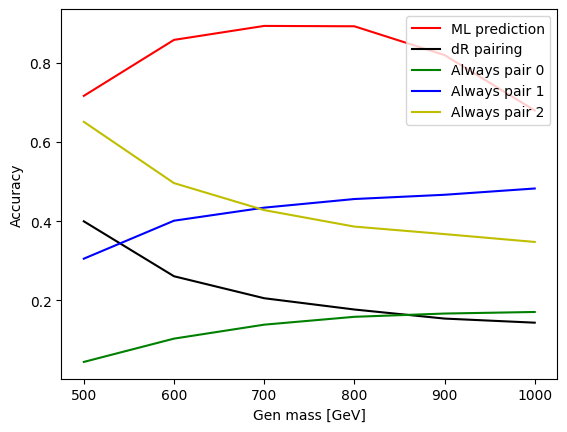

In [48]:
plt.plot(Masses, AccPred, "r", label = "ML prediction")
plt.plot(Masses, AccdR, "k", label = "dR pairing")
plt.plot(Masses, Acc0, "g", label = "Always pair 0")
plt.plot(Masses, Acc1, "b", label = "Always pair 1")
plt.plot(Masses, Acc2, "y", label = "Always pair 2")
plt.legend(loc="upper right")
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.savefig(PlotsDir + "Accuracy_vs_mass.png")

In [49]:
P1Mi = TestingDF.columns.get_loc("P1M")
#TestingDF["dR_M"] = TestingDF.apply(lambda row: row.iloc[row["dRi"]], axis=1)
TestingDF["dR_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["dRi"]]
TestingDF["Truth_high_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_avg"]]
TestingDF["Pred_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Pred"]]
TestingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,-0.385314,-0.292828,-0.304943,-0.410875,-0.762117,0.063545,1.665246,0.650471,0.406185,0.366546,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.569139,0.562562,-0.637817,3.111328,88.057571,0.496791,-0.107071,0.380310,57.543720,0.244333,0.406372,-1.575928,16.302513,0.194699,-1.140137,-1.516113,20.151115,1,500,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,43673.698218,1.296359e+04,2,0.678142,0.092486,0.715818,0.105932,0.698572,0.825663,1,569.138607,569.138607,569.138607,644.228805,1.296359e+04,12963.594113,12963.594113,43673.698218
1,-0.217832,-0.006325,-0.125562,-0.156699,-0.164723,-0.116783,1.109070,0.634266,0.448905,0.308877,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.235760,0.361619,-0.222717,-2.445801,29.381573,0.338603,-0.214935,0.667236,40.997829,0.229120,0.026546,2.607910,14.359166,0.176884,-0.048973,0.241089,24.142027,1,500,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1022.893632,1.624600e+05,1,0.224157,0.211507,0.282261,0.031137,0.281507,0.047940,1,235.760461,482.977846,482.977846,482.977846,1.624600e+05,1022.893632,1022.893632,1022.893632
2,0.238854,0.581879,0.725073,-0.122710,0.206642,0.531022,1.522245,0.581316,0.488398,0.337147,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.473872,0.481394,0.434204,-2.622070,83.461464,0.381080,-0.001941,0.601807,35.842926,0.290538,1.213867,1.445312,27.096323,0.172561,-0.388794,-1.342041,18.913429,1,500,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,63036.149837,4.461916e+03,2,0.820733,0.343024,0.602363,0.847783,0.737664,0.324380,2,473.871794,473.871794,473.871794,473.871794,4.461916e+03,4461.915676,4461.915676,4461.915676
3,-0.633889,-0.193005,-0.791055,-0.319948,-0.635317,-0.502395,2.525532,0.859122,0.317233,0.278710,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.472604,1.214417,-0.781372,1.698242,71.656212,0.945126,-0.447388,-1.610107,65.245651,0.132287,-0.897705,-1.162109,20.544504,0.101560,0.682007,0.441833,18.705877,1,500,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,113750.690667,1.084890e+05,2,0.826894,0.440883,1.111003,0.471107,1.137712,0.132922,1,472.603865,472.603865,472.603865,726.486396,1.084890e+05,108489.023682,108489.023682,113750.690667
4,0.687157,0.112902,0.555835,0.426765,0.607989,0.402100,1.569428,0.596522,0.572933,0.326371,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.567971,0.608950,0.765869,1.446533,41.903107,0.429987,0.579590,-2.564453,33.427315,0.320714,0.167755,-1.186768,25.589222,0.145860,-0.006079,-0.268311,15.420252,1,500,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,159631.460691,1.492244e+02,2,0.800059,0.574255,0.982600,0.129070,1.010089,0.205889,2,567.971112,506.160069,506.160069,506.160069,2.804235e+05,149.224406,149.224406,149.224406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-0.820814,-1.044543,-0.863235,-0.887230,-1.099001,-0.656351,3.103450,0.738637,0.378575,0.304642,2.292324,0.508618,1.174890,1.125380,0.945442,0.784838,0.865140,1.182119,-0.957642,-0.930664,78.492340,1.133891,-0.682739,2.641602,105.238

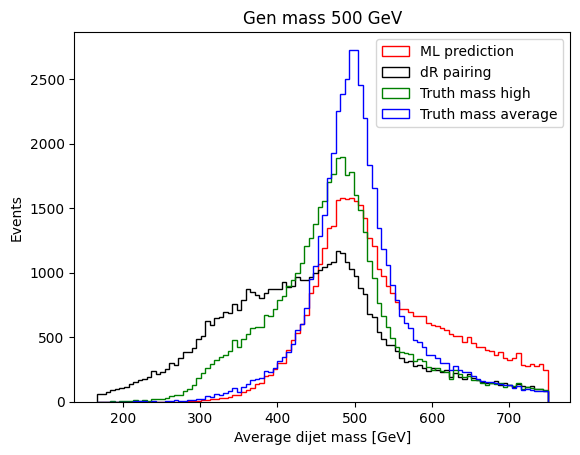

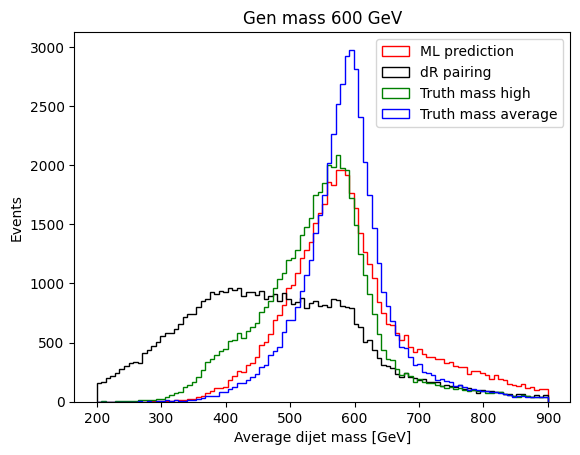

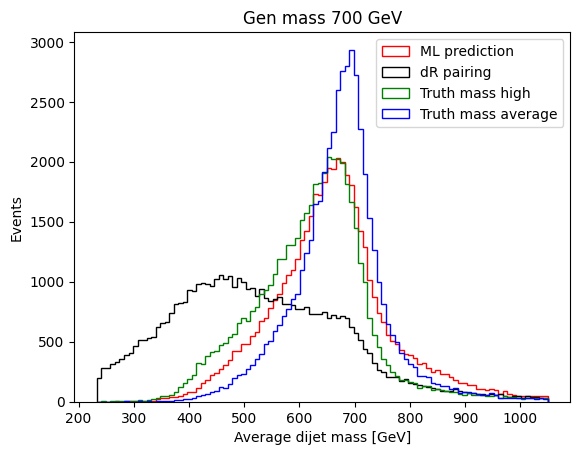

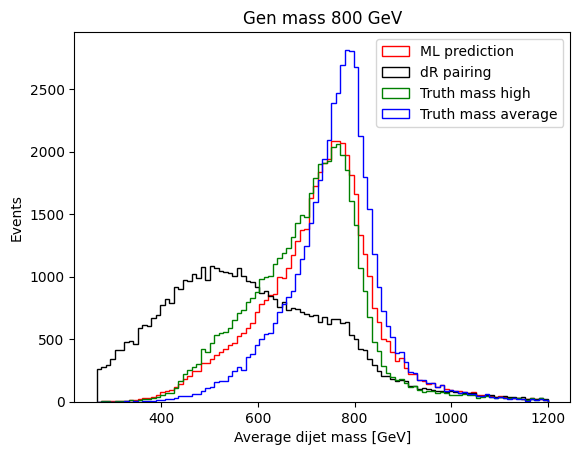

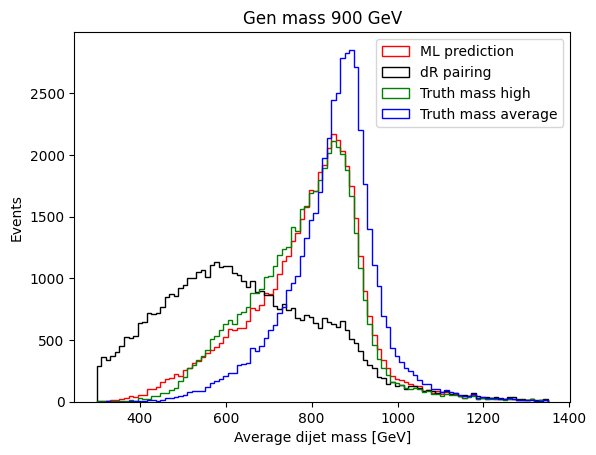

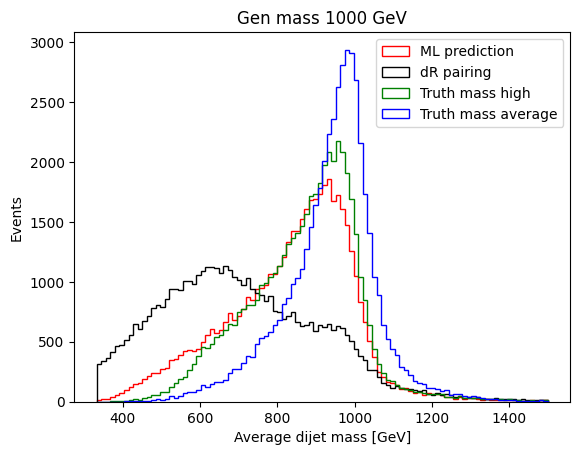

In [50]:
# for each gen mass sample, plot average dijet mass
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "b", label = "Truth mass average")
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Average dijet mass [GeV]")
    plt.ylabel("Events")
    plt.savefig(PlotsDir + "Average_dijet_mass_" + str(Mass) + "GeV.png")

In [51]:
P1QSMDi = TestingDF.columns.get_loc("P1QSMD")
TestingDF["dR_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["dRi"]]
TestingDF["Truth_high_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_avg"]]
TestingDF["Pred_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Pred"]]
TestingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,-0.385314,-0.292828,-0.304943,-0.410875,-0.762117,0.063545,1.665246,0.650471,0.406185,0.366546,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.569139,0.562562,-0.637817,3.111328,88.057571,0.496791,-0.107071,0.380310,57.543720,0.244333,0.406372,-1.575928,16.302513,0.194699,-1.140137,-1.516113,20.151115,1,500,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,43673.698218,1.296359e+04,2,0.678142,0.092486,0.715818,0.105932,0.698572,0.825663,1,569.138607,569.138607,569.138607,644.228805,1.296359e+04,12963.594113,12963.594113,43673.698218
1,-0.217832,-0.006325,-0.125562,-0.156699,-0.164723,-0.116783,1.109070,0.634266,0.448905,0.308877,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.235760,0.361619,-0.222717,-2.445801,29.381573,0.338603,-0.214935,0.667236,40.997829,0.229120,0.026546,2.607910,14.359166,0.176884,-0.048973,0.241089,24.142027,1,500,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1022.893632,1.624600e+05,1,0.224157,0.211507,0.282261,0.031137,0.281507,0.047940,1,235.760461,482.977846,482.977846,482.977846,1.624600e+05,1022.893632,1022.893632,1022.893632
2,0.238854,0.581879,0.725073,-0.122710,0.206642,0.531022,1.522245,0.581316,0.488398,0.337147,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.473872,0.481394,0.434204,-2.622070,83.461464,0.381080,-0.001941,0.601807,35.842926,0.290538,1.213867,1.445312,27.096323,0.172561,-0.388794,-1.342041,18.913429,1,500,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,63036.149837,4.461916e+03,2,0.820733,0.343024,0.602363,0.847783,0.737664,0.324380,2,473.871794,473.871794,473.871794,473.871794,4.461916e+03,4461.915676,4461.915676,4461.915676
3,-0.633889,-0.193005,-0.791055,-0.319948,-0.635317,-0.502395,2.525532,0.859122,0.317233,0.278710,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.472604,1.214417,-0.781372,1.698242,71.656212,0.945126,-0.447388,-1.610107,65.245651,0.132287,-0.897705,-1.162109,20.544504,0.101560,0.682007,0.441833,18.705877,1,500,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,113750.690667,1.084890e+05,2,0.826894,0.440883,1.111003,0.471107,1.137712,0.132922,1,472.603865,472.603865,472.603865,726.486396,1.084890e+05,108489.023682,108489.023682,113750.690667
4,0.687157,0.112902,0.555835,0.426765,0.607989,0.402100,1.569428,0.596522,0.572933,0.326371,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.567971,0.608950,0.765869,1.446533,41.903107,0.429987,0.579590,-2.564453,33.427315,0.320714,0.167755,-1.186768,25.589222,0.145860,-0.006079,-0.268311,15.420252,1,500,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,159631.460691,1.492244e+02,2,0.800059,0.574255,0.982600,0.129070,1.010089,0.205889,2,567.971112,506.160069,506.160069,506.160069,2.804235e+05,149.224406,149.224406,149.224406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-0.820814,-1.044543,-0.863235,-0.887230,-1.099001,-0.656351,3.103450,0.738637,0.378575,0.304642,2.292324,0.508618,1.174890,1.125380,0.945442,0.784838,0.865140,1.182119,-0.957642,-0.930664,78.492340,1.133891,-0.682739,2.641602,105.238

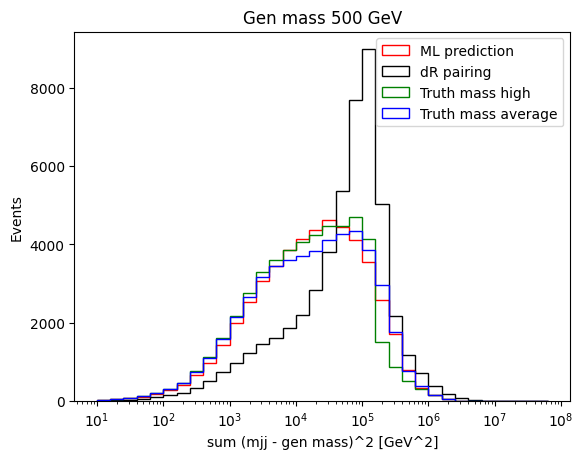

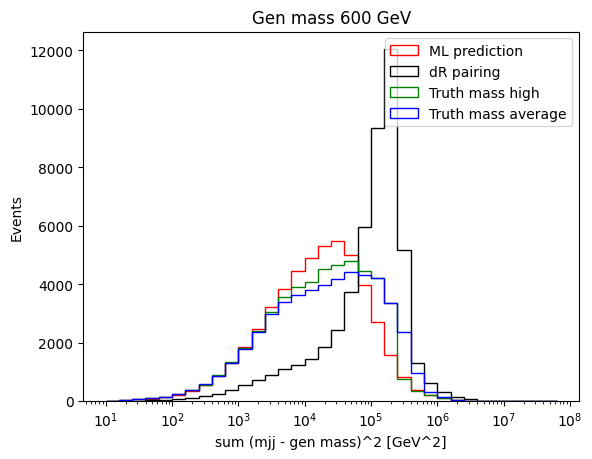

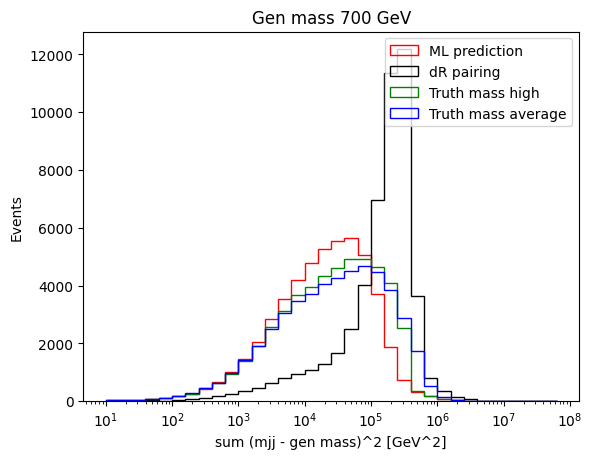

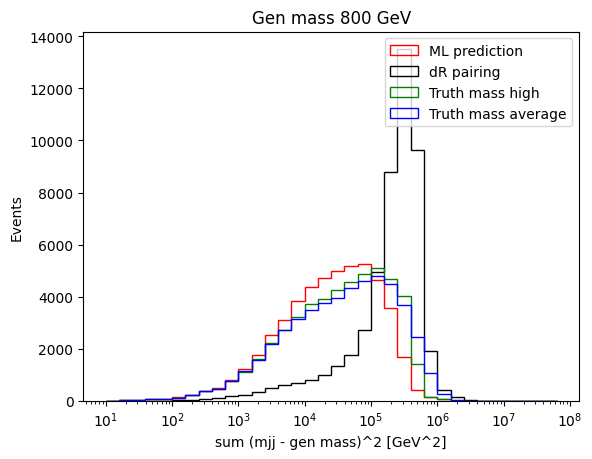

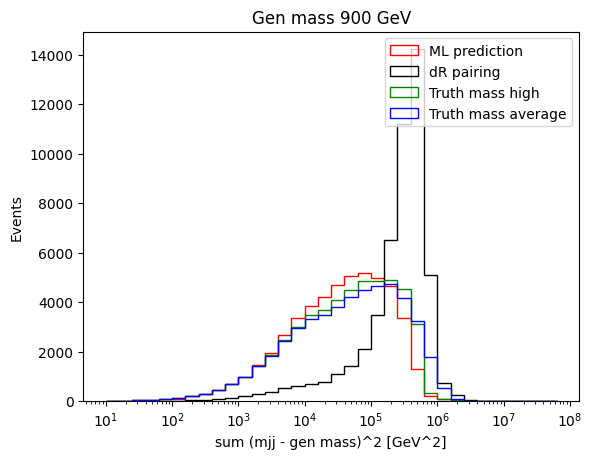

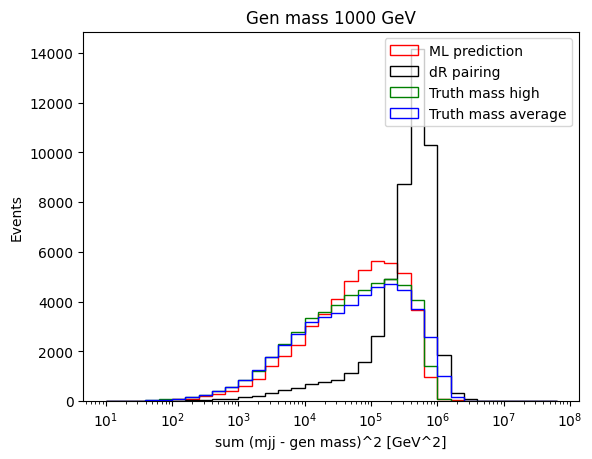

In [52]:
# for each gen mass sample, plot dijet mass high
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    Bins = [10**(x/5) for x in range(5,40)]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_QSMD"], bins = Bins, histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_QSMD"], bins = Bins, histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_QSMD"], bins = Bins, histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_QSMD"], bins = Bins, histtype = "step", color = "b", label = "Truth mass average")
    plt.xscale('log')
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("sum (mjj - gen mass)^2 [GeV^2]")
    plt.ylabel("Events")
    plt.savefig(PlotsDir + "quad_sum_mass_diff_" + str(Mass) + "GeV.png")